# RTMA: Regional temperature map

## Overview:
1. Retrieve and plot 2m temperature from the 2.5 km real-time mesoscale analysis (RTMA)
2. Overlay text values of RTMA 2m T at several locations.

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| Matplotlib  | Necessary |
| Xarray  | Necessary|

* **Time to learn**: 20 minutes
***

## Imports

In [27]:
from datetime import datetime
import numpy as np
import matplotlib.patheffects as PathEffects
import matplotlib.colors as colors
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import USCOUNTIES
from siphon.catalog import TDSCatalog
from gradient import Gradient
import pytz
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import shapely.geometry as sgeom
from copy import copy

Read in a table of cities, which includes their lat/lon coordinates.

In [2]:
ds = pd.read_csv('/spare11/atm350/mb127935/Cities/Northeast_Cities.csv')
cities = ds.city
cityLat = ds.lat
cityLon = ds.lon

Use **Siphon** to access and retrieve the latest RTMA grid from Unidata's THREDDS server. Apply the CF conventions to the Xarray `Dataset` and then examine the `Dataset`.

In [4]:
rtma_cat = TDSCatalog('https://thredds.ucar.edu/thredds/catalog/grib/NCEP/RTMA/CONUS_2p5km/catalog.xml')
rtma_data = rtma_cat.datasets['Latest Collection for Real Time Mesoscale Analysis 2.5 km'].remote_access(use_xarray=True)
rtma_data =rtma_data.metpy.parse_cf()

<xarray.Dataset>
Dimensions:                                                              (
                                                                          time1: 1,
                                                                          : 2,
                                                                          x: 2145,
                                                                          y: 1377,
                                                                          time: 1,
                                                                          height_above_ground: 1,
                                                                          altitude_above_msl: 1,
                                                                          height_above_ground1: 1)
Coordinates:
    reftime                                                              datetime64[ns] ...
  * time1                                                                (time1) datetime64[ns] ...
  * x                                                                    (x) float32 ...
  * y                                                                    (y) float32 ...
  * time                                                                 (time) datetime64[ns] ...
  * height_above_ground                                                  (height_above_ground) float32 ...
    metpy_crs                                                            object ...
  * altitude_above_msl                                                   (altitude_above_msl) float32 ...
  * height_above_ground1                                                 (height_above_ground1) float32 ...
Dimensions without coordinates: 
Data variables: (12/22)
    LambertConformal_Projection                                          int32 ...
    time1_bounds                                                         (time1, ) datetime64[ns] ...
    Dewpoint_temperature_error_height_above_ground                       (time, height_above_ground, y, x) float32 ...
    Dewpoint_temperature_Analysis_height_above_ground                    (time, height_above_ground, y, x) float32 ...
    Geopotential_height_Analysis_surface                                 (time, y, x) float32 ...
    Pressure_error_surface                                               (time, y, x) float32 ...
    ...                                                                   ...
    Wind_speed_error_height_above_ground                                 (time, height_above_ground1, y, x) float32 ...
    Wind_speed_Analysis_height_above_ground                              (time, height_above_ground1, y, x) float32 ...
    Wind_speed_gust_error_height_above_ground                            (time, height_above_ground1, y, x) float32 ...
    Wind_speed_gust_Analysis_height_above_ground                         (time, height_above_ground1, y, x) float32 ...
    u-component_of_wind_Analysis_height_above_ground                     (time, height_above_ground1, y, x) float32 ...
    v-component_of_wind_Analysis_height_above_ground                     (time, height_above_ground1, y, x) float32 ...
Attributes:
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    file_format:                                                             ...
    Conventions:                                                             ...
    history:                                                                 ...
    featureType:                                                             ...
    _CoordSysBuilder:                                                        ...

In [5]:
temp = rtma_data.Temperature_Analysis_height_above_ground

Read in the temperature array from the full dataset; squeeze out the single-value dimensions, and convert to Fahrenheit

In [6]:
tempFullF = rtma_data.Temperature_Analysis_height_above_ground.squeeze().metpy.convert_units('degF')

The valid time is the first (and only) element of the `time` coordinate. Use it to create a couple of string objects we'll use to label the figure and name the output graphic file.

In [7]:
valTime = rtma_data.time.values[0]
validTime = pd.to_datetime(str(rtma_data.time.values[0]))
validTimeStr = validTime.strftime("%Y-%m-%d %H:%M")
validTimeStrFile = validTime.strftime("%Y%m%d%H")
eastern_time = datetime.strptime(validTimeStr,'%Y-%m-%d %H:%M').astimezone(pytz.timezone('US/Eastern')).strftime("%Y-%m-%d %H:%M")
print(eastern_time)
print("Model valid time: ",validTimeStr)

2022-06-05 16:00
Model valid time:  2022-06-05 20:00


In [8]:
t = time.strptime(eastern_time, "%Y-%m-%d %H:%M")
timevalue_12hour = time.strftime( "%I:%M %p EDT", t,)
print(timevalue_12hour)

04:00 PM EDT


Define data and map subregion; set projection

Note that we have to include the standard latitude (25 North in this case) as well as the central lat/lons. The default standard latitudes for a Lambert Conformal projection are 33 and 45 N. Using those values will result in a distorted plot, which in this case can easily be revealed by an eastward displacement of temperatures in the vicinity of the Great Lakes.

Also, Cartopy's Lambert Conformal projection assumes a globe with an oblate spheroid shape. NCEP's representation in its numerical models is that of a true sphere, with radius 6371200 km.

In [9]:
lonW = -84
lonE = -66
latS = 37
latN = 47.5
cLat, cLon = (latS + latN)/2, (lonW + lonE)/2
proj_map = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

dataCenLon = rtma_data.LambertConformal_Projection.longitude_of_central_meridian
dataCenLat = rtma_data.LambertConformal_Projection.latitude_of_projection_origin
dataStdLat = rtma_data.LambertConformal_Projection.standard_parallel
print(dataCenLon, dataCenLat)
print (dataStdLat)
radius = 6371200.0
globe = ccrs.Globe(semimajor_axis=radius, semiminor_axis=radius)
proj_data = ccrs.LambertConformal(central_longitude=dataCenLon, central_latitude=dataCenLat, standard_parallels=(dataStdLat,), globe=globe)

265.0 25.0
25.0


Transform the subregion corners' lat/lon coordinates into the RTMA grid coordinates.

In [10]:
SW = proj_data.transform_point(lonW, latS, ccrs.PlateCarree())
NW = proj_data.transform_point(lonW, latN, ccrs.PlateCarree())
SE = proj_data.transform_point(lonE, latS, ccrs.PlateCarree())
NE = proj_data.transform_point(lonE, latN, ccrs.PlateCarree())

Resample over the subregion. Note that the increment cannot be any less than the minimum distance between gridpoints. The distance, curiously, varies between 2539.5 and 2539.75

In [11]:
distance = 2540

In order for the data region to fill the plotted region, pad the x and y ranges (trial and error)

In [12]:
xPad = 450000
yPad = 200000

Create the ranges for the x- and y- coordinates, which will then be used in the Xarray's `sel` method.

In [13]:
xRange = np.arange(int(SW[0]) - xPad, int(NE[0] + xPad), distance)

In [14]:
yRange = np.arange(int(SW[1]) - yPad, int(NE[1] + yPad), distance)

Read in the temperature data, over the selected region.

In [15]:
temp = rtma_data['Temperature_Analysis_height_above_ground'].sel(x=xRange, y=yRange, method='nearest').squeeze()

Get a quick look at the data using Xarray's `plot` function.

Convert to degrees F, then examine the `DataArray`.

In [16]:
tempF = temp.metpy.convert_units('degF')


Create objects for the horizontal coordinate dimensions from this subsetted `DataArray`.

In [17]:
x = temp.metpy.x
y = temp.metpy.y

Cartopy has functions to transform arrays of coordinates from one projection to another. Use `transform_points` to transform the cities' lat/lon coordinates into the RTMA (Lambert Conformal Conic) grid coordinates.

In [18]:
pointsGrid = proj_data.transform_points(ccrs.PlateCarree(),cityLon, cityLat)

The `transform_points` function returns a 3-dimensional NumPy array, consisting of the transformed x, y, and z coordinates (in this case, z is 0 everywhere so it can be ignored).

In [19]:
xCities, yCities = pointsGrid[:,0], pointsGrid[:,1]

Create the figure's title string.

In [20]:
tl1 = "Current Temperatures ($^\circ$F)"
tl2 = str('Valid at: '+timevalue_12hour)
title_line = (tl1 + '\n' + tl2 + '\n')

Specify the Cartopy cartographic feature resolution.

In [21]:
res = '10m'

Set the range of colors for the gridded field.

In [22]:
bounds = np.arange(-60,130,0.5)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=379)
obj = Gradient([['#36365e',-60.0],['#5097d9',-50.0]],
               [['#5097d9',-50.0],['#2f8764',-40.0]],
               [['#2f8764',-40.0],['#33f5f5',-30.0]],
               [['#33f5f5',-30.0],['#a422b3',-20.0]],
               [['#a422b3',-20.0],['#47064f',-10.0]],
               [['#47064f',-10.0],['#efedf0',0.0]],
               [['#7e7cf7',0.0],['#020b96',10.0]],
               [['#020b96',10.0],['#0047ab',20.0]],
               [['#0047ab',20.0],['#00fffb',32.0]],
               [['#15d15a',32.0],['#00751b',40.0]],
               [['#00751b',40.0],['#67cf00',50.0]],
               [['#67cf00',50.0],['#fbff00',60.0]],
               [['#fbff00',60.0],['#ffae00',70.0]],
               [['#ffae00',70.0],['#de0000',80.0]],
               [['#de0000',80.0],['#96002d',90.0]],
               [['#96002d',90.0],['#e096ad',100.0]],
               [['#e096ad',100.0],['#ad727a',110.0]],
               [['#ad727a',110.0],['#78344b',120]],
               [['#78344b',120.0],['#521d2c',130]])
cmap = obj.get_cmap(bounds) #Retrieve colormap
colors = obj.colors #Retrieve list of hex color values

In [23]:
def find_side(ls, side):
    """
    Given a shapely LineString which is assumed to be rectangular, return the
    line corresponding to a given side of the rectangle.
    
    """
    minx, miny, maxx, maxy = ls.bounds
    points = {'left': [(minx, miny), (minx, maxy)],
              'right': [(maxx, miny), (maxx, maxy)],
              'bottom': [(minx, miny), (maxx, miny)],
              'top': [(minx, maxy), (maxx, maxy)],}
    return sgeom.LineString(points[side])


def lambert_xticks(ax, ticks):
    """Draw ticks on the bottom x-axis of a Lambert Conformal projection."""
    te = lambda xy: xy[0]
    lc = lambda t, n, b: np.vstack((np.zeros(n) + t, np.linspace(b[2], b[3], n))).T
    xticks, xticklabels = _lambert_ticks(ax, ticks, 'bottom', lc, te)
    ax.xaxis.tick_bottom()
    ax.set_xticks(xticks)
    ax.set_xticklabels([ax.xaxis.get_major_formatter()(xtick) for xtick in xticklabels])
    

def lambert_yticks(ax, ticks):
    """Draw ricks on the left y-axis of a Lamber Conformal projection."""
    te = lambda xy: xy[1]
    lc = lambda t, n, b: np.vstack((np.linspace(b[0], b[1], n), np.zeros(n) + t)).T
    yticks, yticklabels = _lambert_ticks(ax, ticks, 'left', lc, te)
    ax.yaxis.tick_left()
    ax.set_yticks(yticks)
    ax.set_yticklabels([ax.yaxis.get_major_formatter()(ytick) for ytick in yticklabels])

def _lambert_ticks(ax, ticks, tick_location, line_constructor, tick_extractor):
    """Get the tick locations and labels for an axis of a Lambert Conformal projection."""
    outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())
    axis = find_side(outline_patch, tick_location)
    n_steps = 30
    extent = ax.get_extent(ccrs.PlateCarree())
    _ticks = []
    for t in ticks:
        xy = line_constructor(t, n_steps, extent)
        proj_xyz = ax.projection.transform_points(ccrs.Geodetic(), xy[:, 0], xy[:, 1])
        xyt = proj_xyz[..., :2]
        ls = sgeom.LineString(xyt.tolist())
        locs = axis.intersection(ls)
        if not locs:
            tick = [None]
        else:
            tick = tick_extractor(locs.xy)
        _ticks.append(tick[0])
    # Remove ticks that aren't visible:    
    ticklabels = copy(ticks)
    while True:
        try:
            index = _ticks.index(None)
        except ValueError:
            break
        _ticks.pop(index)
        ticklabels.pop(index)
    return _ticks, ticklabels

Create the figure. Use Matplotlib's `pcolormesh` rather than `contourf`; the former is much faster on a large grid such as this.

/tmp/ipykernel_19086/3940785299.py:36: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  outline_patch = sgeom.LineString(ax.outline_patch.get_path().vertices.tolist())


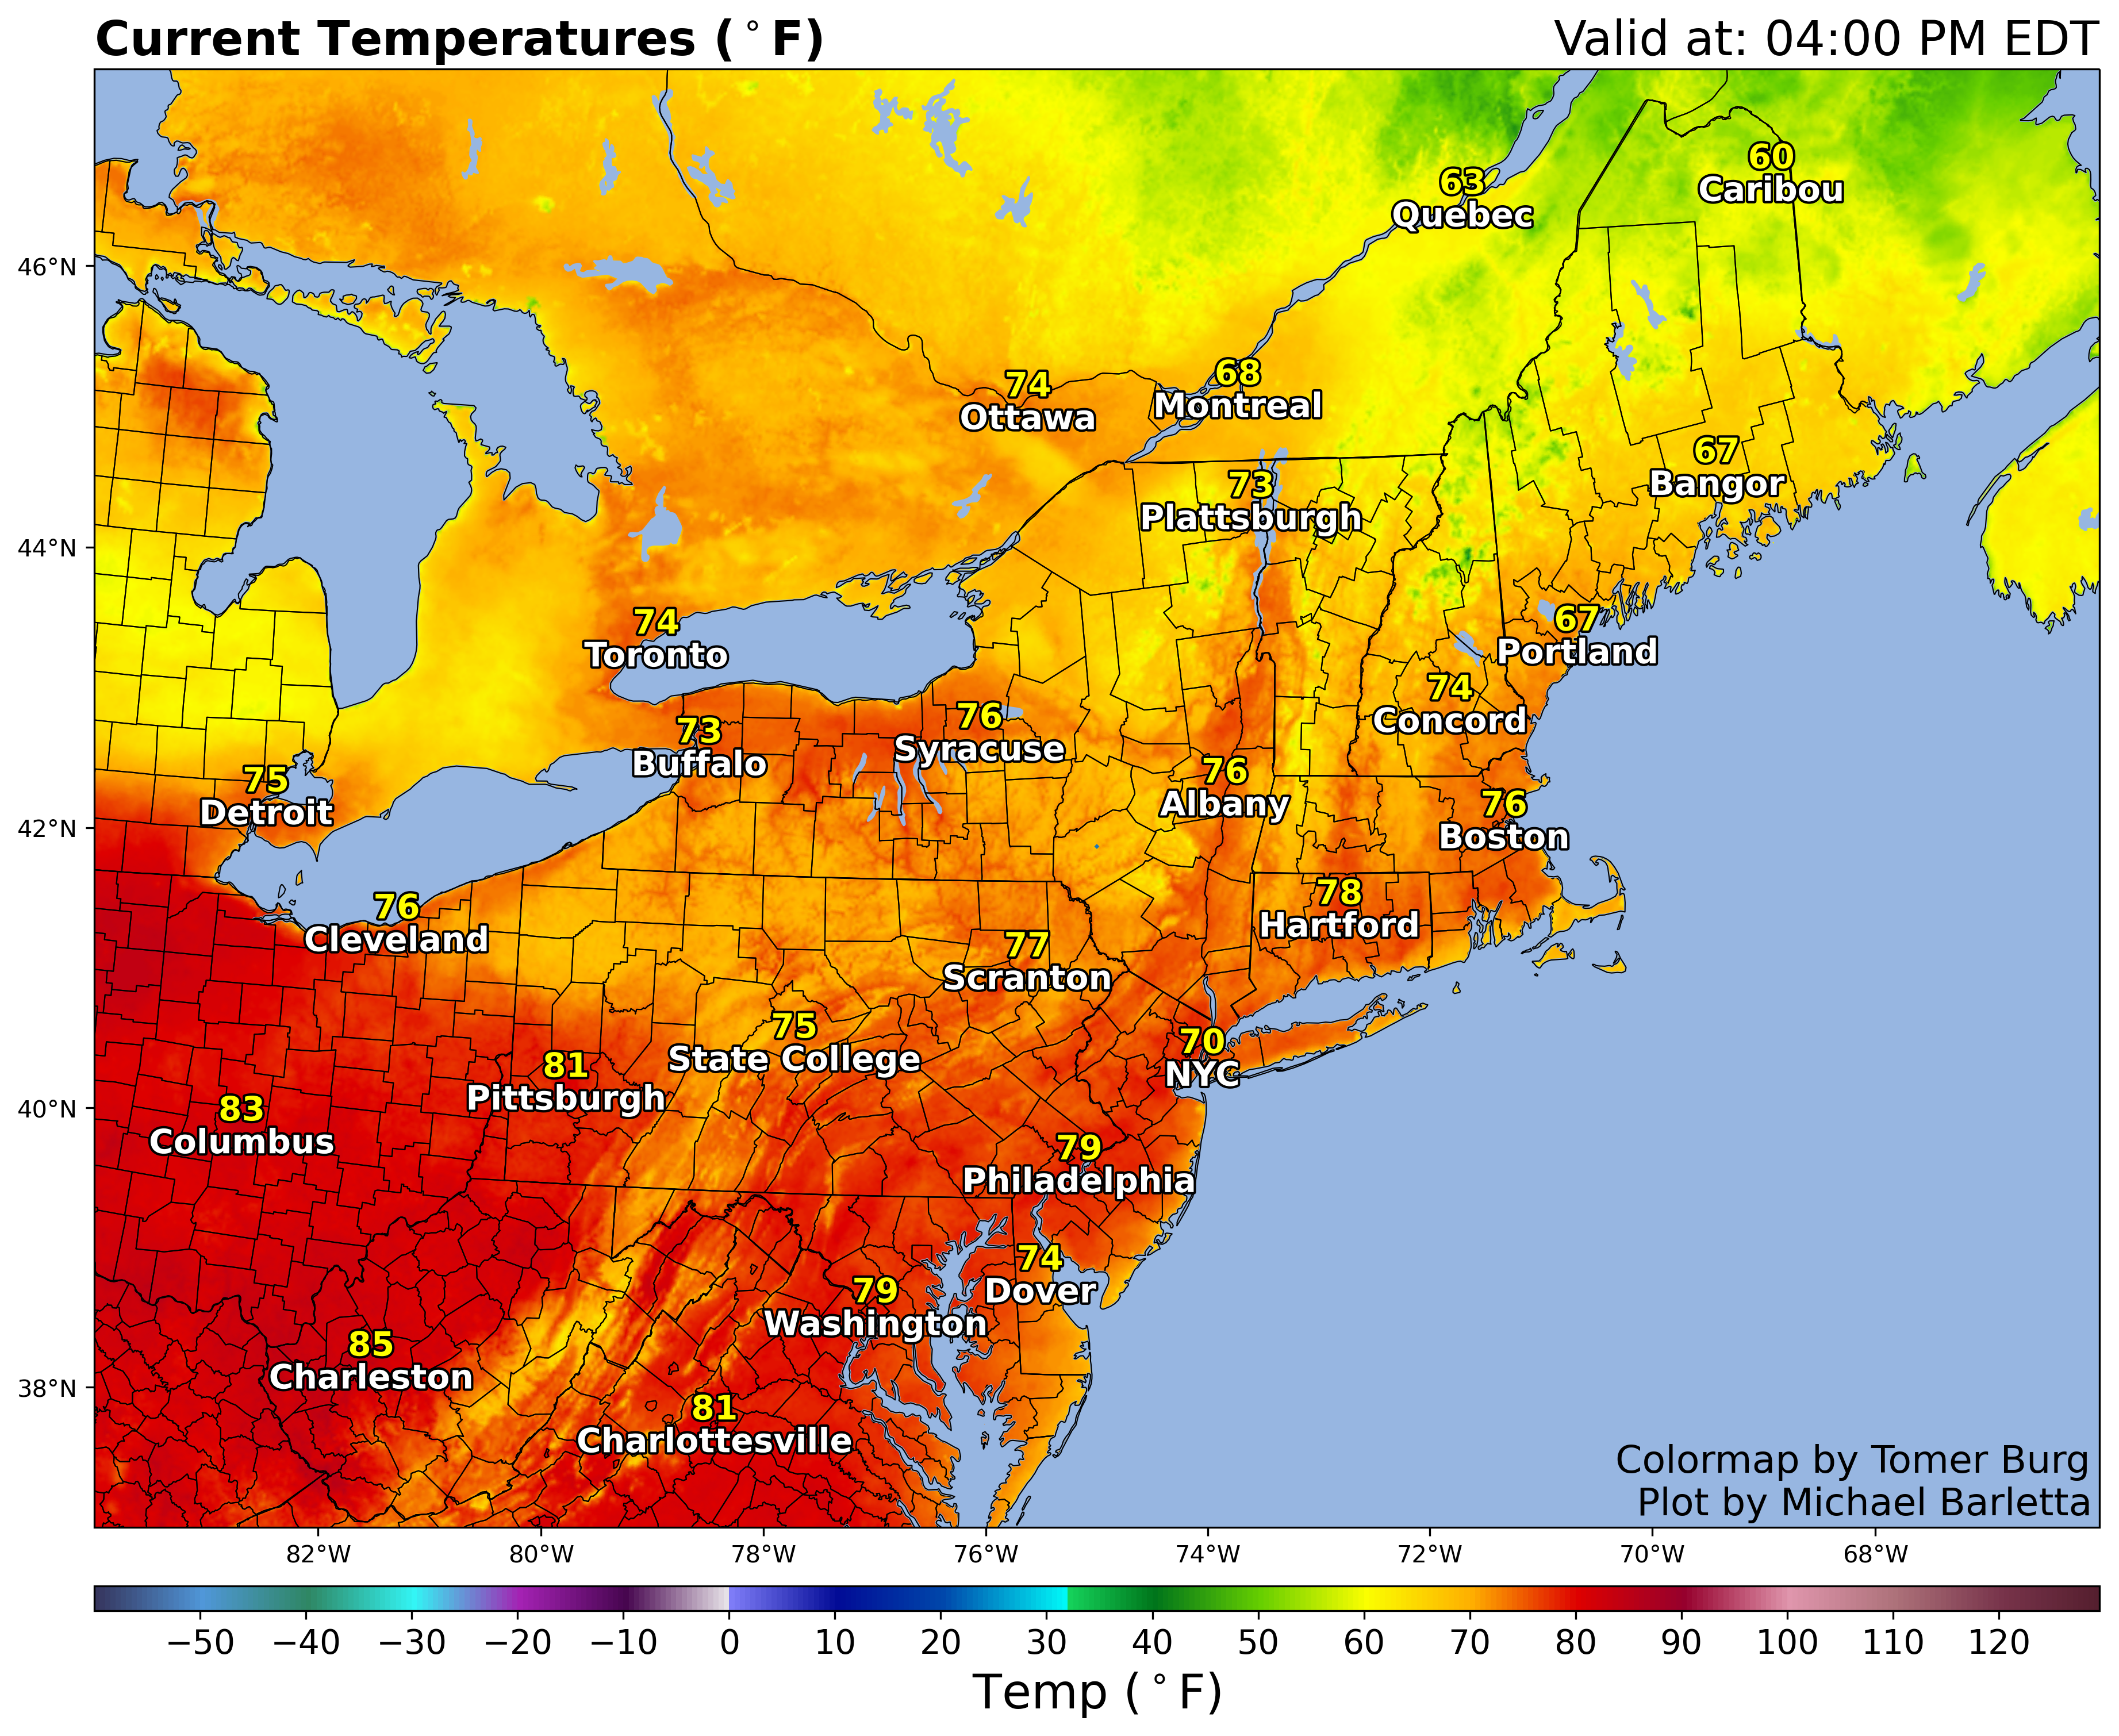

In [31]:
fig = plt.figure(figsize=(15,15), dpi=300)
ax = fig.add_subplot(1,1,1, projection=proj_map)
ax.plot([0,1],[1,0])
ax.set_aspect(1)
ax.set_extent([lonW, lonE, latS, latN])

# Create the colormesh
CT = ax.pcolormesh(x,y,tempF, transform=proj_data, norm=norm, cmap=cmap, shading='gouraud')

# Create the colorbar based on the colormesh
cbar = fig.colorbar(CT,orientation='horizontal', pad=0.03, aspect = 80)
cbar.ax.tick_params(labelsize=14)
cbar.set_ticks([-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120])
cbar.ax.set_xlabel("Temp ($^\circ$F)",fontsize=20)

# Add the Natural Earth features (it doesn't seem advisable to include the water features)
ax.add_feature(cfeature.COASTLINE.with_scale(res), linewidth=0.5, zorder=3)
ax.add_feature(cfeature.BORDERS.with_scale(res), linewidth=0.5)
ax.add_feature(cfeature.OCEAN.with_scale(res), zorder=2)
ax.add_feature(cfeature.LAKES.with_scale(res))
ax.add_feature(cfeature.STATES.with_scale(res), linewidth=0.5)
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.5)

#setting lat lon ticks, difficult with lambert projection
fig.canvas.draw()

xticks = [-66,-68,-70,-72,-74, -76, -78,-80,-82]
yticks = [38,40,42,44,46,48]
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
lambert_xticks(ax, xticks)
lambert_yticks(ax, yticks)


# At each city's coordinates, plot the temperature values from the closest gridpoint.
for idx, city in enumerate(cities):
    val = int((tempFullF.sel(x = xCities[idx], y = yCities[idx], method='nearest').values) + .5)
    txt=ax.text(xCities[idx], yCities[idx], val,horizontalalignment='center',verticalalignment='bottom', fontsize=14, color='yellow', fontvariant='small-caps', fontweight='bold', transform=proj_data)
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black')]) 
    
for count, city in enumerate(cities):
    txt=ax.text(cityLon[count],cityLat[count],city,horizontalalignment='center',verticalalignment='top', transform=ccrs.PlateCarree(),fontsize=14, color='white', fontvariant='small-caps', fontweight='bold')
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black')])

#plt.gca().set_position([0, 0, 1, 1])

# Set the title
ax.set_title('Current Temperatures ($^\circ$F)',fontsize=20, loc='left', weight='bold')
ax.set_title('Valid at: ' + timevalue_12hour ,fontsize=20, loc='right')


ax.text(0.88, 0.03,'Colormap by Tomer Burg \n Plot by Michael Barletta',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,
     fontsize = 16
            )

# Save the figure to disk
fig.savefig('RTMA_TMPF_NE_' + validTimeStrFile + '.png', facecolor='white', bbox_inches='tight') 

## Future work
- Improve readability of the text-based temperature values
- Investigate why Xarray's `nearest` option fails when the DataArray is a subset of the full RTMA Dataset
- Overlay actual temperatures rather than / in addition to RTMA's values at site locations

## References

1. [RTMA info](https://nomads.ncep.noaa.gov/txt_descriptions/RTMA_doc.shtml)
1. [MetPy and Xarray Tutorial](https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html)
1. [Climate and Forecast (CF) Conventions and Coordinate Reference System](http://cfconventions.org/Data/cf-conventions/cf-conventions-1.8/cf-conventions.html#grid-mappings-and-projections)